In [161]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
torch.manual_seed(0)

#### Activate GPU


In [162]:
device=torch.device("mps")

Helper Functions

In [163]:

def  get_data(data):
    data=data.iloc[:,3:4]
    train_size=int(len(data)*0.7)
    validation_size=int(train_size*0.2)
    test_data=data[train_size:]
    val_data=data[0:validation_size]
    train_data=data[validation_size:train_size]
    return test_data,val_data,train_data

def  get_data_multi(data):
    
    train_size=int(len(data)*0.7)
    validation_size=int(train_size*0.2)
    test_data=data[train_size:]
    val_data=data[0:validation_size]
    train_data=data[validation_size:train_size]
    return test_data,val_data,train_data

    
def genrate_data(seq_data,seq_length):
    data_x=[]
    data_y=[]
    for i in range(0,len(seq_data)-seq_length):
        x=np.array(seq_data.iloc[i:i+seq_length,:])
        y=np.array(seq_data.iloc[i+seq_length,:])
        # y=seq_data[i+seq_length]
    
        data_x.append(x)
        data_y.append(y)
        
    return np.array(data_x),np.array(data_y)
def genrate_data_multi(seq_data,seq_length):
    data_x=[]
    data_y=[]
    for i in range(0,len(seq_data)-seq_length):
        x=np.array(seq_data.iloc[i:i+seq_length,:])
        y=np.array(seq_data.iloc[i+seq_length,:])
        # y=seq_data[i+seq_length]
    
        data_x.append(x)
        data_y.append(y)
        
    return np.array(data_x),np.array(data_y)


def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)



def pre_process_data(x):
    x=minmax_scaler(x)
    x=torch.from_numpy(x).float()
    return x


def diagnostic_plots(loss1,lable1,loss2,lable2):
    plt.plot(loss1,label= lable1)
    plt.plot(loss2,label=lable2)
    plt.legend()
    plt.show()

    
def test_model(model,test_data_X,test_data_Y):
    outputs=model.forward(test_data_X).detach().numpy()
    diagnostic_plots(outputs,"Predicted",test_data_Y,"Actual")
    print("RMSE: ",math.sqrt(mean_squared_error(outputs,test_data_Y)))


#### Get Stock Data

In [164]:
data=pd.read_csv("./Dataset/ADBE.csv")  # ADOBE Stock Data
data_test=pd.read_csv("./Dataset/ABUS.csv")  #ABUS Stock Data 

test_data,val_data,train_data=get_data(data)
test_data_A,val_data_A,train_data_A=get_data(data_test)

#### Data Split to Train Test and Validation Sets

In [165]:
#train data
train_x,train_y=genrate_data(train_data,20)
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

#test data
test_x,test_y=genrate_data(test_data,20)
X_test=pre_process_data(test_x)
Y_test=pre_process_data(test_y)

#validation data
val_x,val_y=genrate_data(val_data,20)
X_val=pre_process_data(val_x)
Y_val=pre_process_data(val_y)




In [166]:
train_data=torch.utils.data.TensorDataset(X_train,Y_train)
val_data=torch.utils.data.TensorDataset(X_val,Y_val)


Initial Model paramters

In [167]:
learning_rate=0.01
epochs=50

## Vanilla RNN

In [168]:
class Vanila_RNN(nn.Module):
    def __init__(self):
        super(Vanila_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,_status=self.rnn(X,h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out

In [169]:
def train(model):
    
    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss=[]
    validation_loss=[]
    train_rmse=[]
    val_rmse=[]
    for i in range(epochs):
            # zero the gradients as we dont want to accumulate it.
            optimizer.zero_grad()
            #calculate yhats/outputs
            outputs = model(X_train)
           
            #calculate loss using mse
            loss = criterion(outputs, Y_train)
            #calculating gradients
            loss.backward()
            #updating the parameters using adam optim
            optimizer.step()
            #append the train loss of i th epoch to list of losses
            train_loss.append(loss.item())
            # predict for validation test set
            val_output=model(X_val)
            #append the validation loss of i th epoch to list of losses
            validation_loss.append(criterion(val_output,Y_val).item())

            #append train rmse of the model
            train_rmse.append(math.sqrt(mean_squared_error(outputs.detach().numpy(),Y_train)))
            
            #append validation rmse of the model
            val_rmse.append(math.sqrt(mean_squared_error(val_output.detach().numpy(),Y_val)))
            #print losses per 50 epoch
            if (i+1) % 5 == 0:
                print(f'epoch {i}, training loss : {loss.item()}')
    return train_loss,validation_loss,train_rmse,val_rmse


In [170]:
vanilla_model=Vanila_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 4, training loss : 0.08907574415206909
epoch 9, training loss : 0.06883715838193893
epoch 14, training loss : 0.04367509111762047
epoch 19, training loss : 0.012232281267642975
epoch 24, training loss : 0.010992705821990967
epoch 29, training loss : 0.0031075410079210997
epoch 34, training loss : 0.0030992734245955944
epoch 39, training loss : 0.0027126073837280273
epoch 44, training loss : 0.000768871686886996
epoch 49, training loss : 0.0015145151410251856


##### Train and Validation RMSE Plots

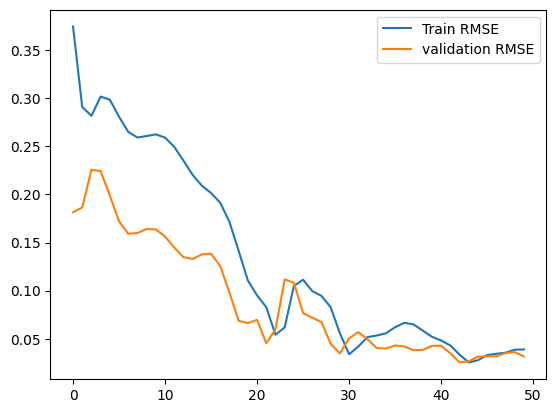

In [171]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

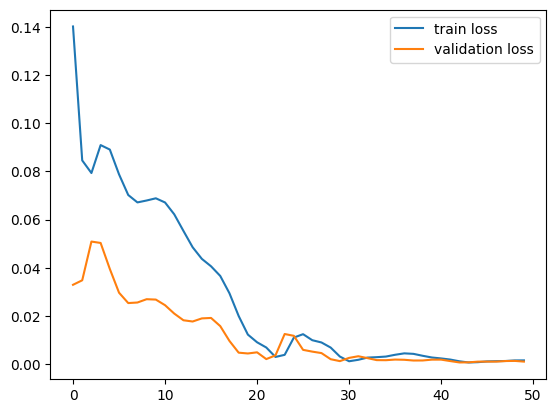

In [172]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

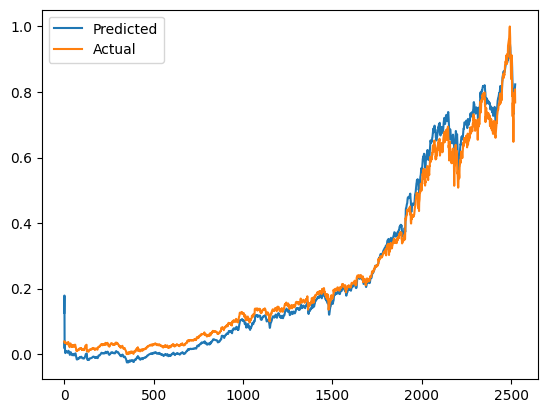

RMSE:  0.030003244643968106


In [173]:
test_model(vanilla_model,X_test,Y_test)

# LSTM RNN

In [174]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
    
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        c0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,(hn, cn) = self.rnn(X, (h0, c0))
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out
    

In [175]:
model_LSTM=LSTM_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(model_LSTM)

epoch 4, training loss : 0.09942605346441269
epoch 9, training loss : 0.0865156427025795
epoch 14, training loss : 0.07947345077991486
epoch 19, training loss : 0.06941866874694824
epoch 24, training loss : 0.053806524723768234
epoch 29, training loss : 0.026053812354803085
epoch 34, training loss : 0.011819939129054546
epoch 39, training loss : 0.010054615326225758
epoch 44, training loss : 0.004953476600348949
epoch 49, training loss : 0.005057199392467737


##### Train and Validation RMSE Plots

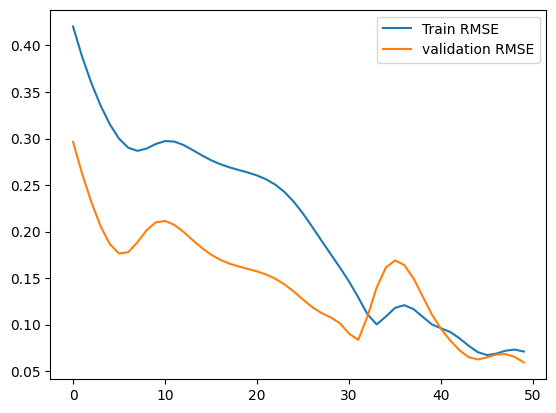

In [176]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

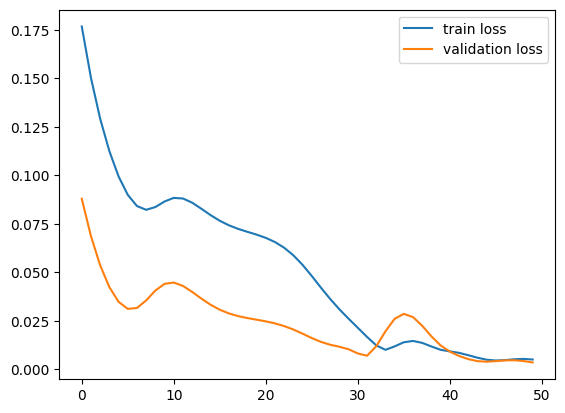

In [177]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

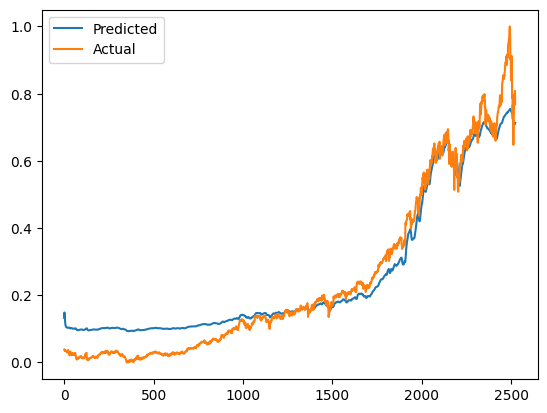

RMSE:  0.05703279569895816


In [178]:
test_model(model_LSTM,X_test,Y_test)

# GRU RNN

In [179]:
class GRU_RNN(nn.Module):
    def __init__(self):
        super(GRU_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
    
        self.rnn = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        
        rnn_out,(hn, cn) = self.rnn(X, h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out
    

In [180]:
gru_model=GRU_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(gru_model)

epoch 4, training loss : 0.06705474853515625
epoch 9, training loss : 0.06386333703994751
epoch 14, training loss : 0.04645034670829773
epoch 19, training loss : 0.019606633111834526
epoch 24, training loss : 0.006021289154887199
epoch 29, training loss : 0.009775386191904545
epoch 34, training loss : 0.0019584165420383215
epoch 39, training loss : 0.0018413708312436938
epoch 44, training loss : 0.0019276529783383012
epoch 49, training loss : 0.0008414644980803132


##### Train and Validation RMSE Plots

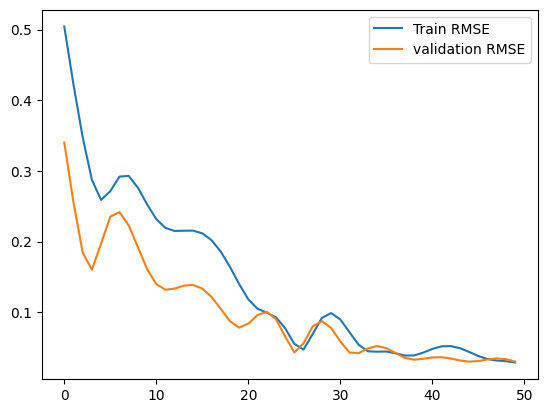

In [181]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

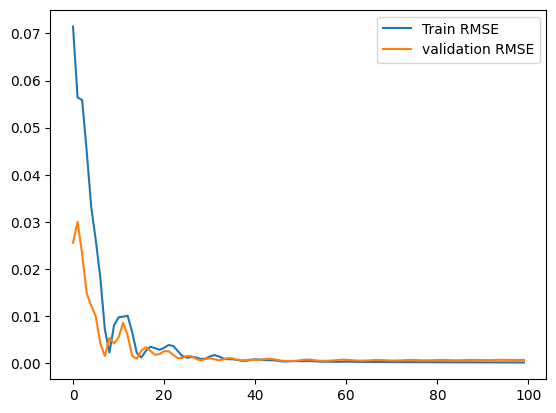

In [202]:
diagnostic_plots(train_loss,"Train RMSE",validation_loss,"validation RMSE")

#### Train and Validation Test Loss Plots

#### Model Performance in the Test Data

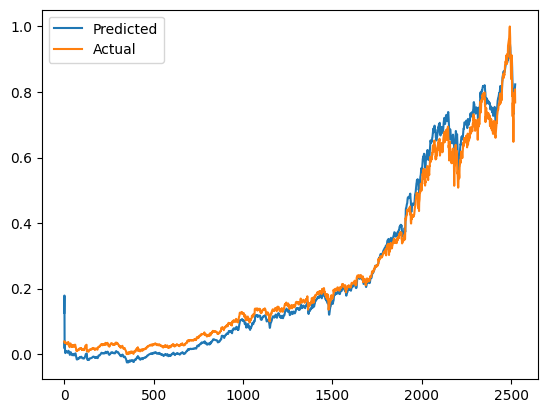

RMSE:  0.030003244643968106


In [182]:
test_model(vanilla_model,X_test,Y_test)

## Experiments 

##### Window Size

In [184]:
data=pd.read_csv("./Dataset/ADBE.csv")  # ADOBE Stock Data
data_test=pd.read_csv("./Dataset/ABUS.csv")  #ABUS Stock Data 

test_data,val_data,train_data=get_data(data)
test_data_A,val_data_A,train_data_A=get_data(data_test)

window_size=40

train_x,train_y=genrate_data(train_data,window_size)
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

#test data
test_x,test_y=genrate_data(test_data,window_size)
# test_x=test_x[1:100,:,:]
# test_y=test_y[1:100,:]
X_test=pre_process_data(test_x)
Y_test=pre_process_data(test_y)

#validation data
val_x,val_y=genrate_data(val_data,window_size)
X_val=pre_process_data(val_x)
Y_val=pre_process_data(val_y)


In [185]:
epochs=50


In [186]:
vanilla_model=Vanila_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 4, training loss : 0.08628357946872711
epoch 9, training loss : 0.06818962842226028
epoch 14, training loss : 0.0387955866754055
epoch 19, training loss : 0.007943875156342983
epoch 24, training loss : 0.010839383117854595
epoch 29, training loss : 0.004181818105280399
epoch 34, training loss : 0.004267722833901644
epoch 39, training loss : 0.0015575968427583575
epoch 44, training loss : 0.0015661704819649458
epoch 49, training loss : 0.0006937525467947125


##### Train and Validation RMSE Plots

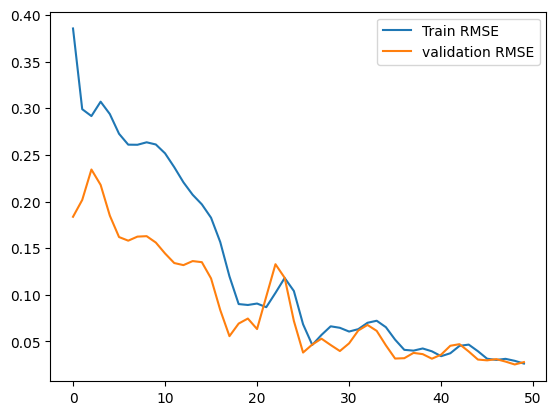

In [187]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

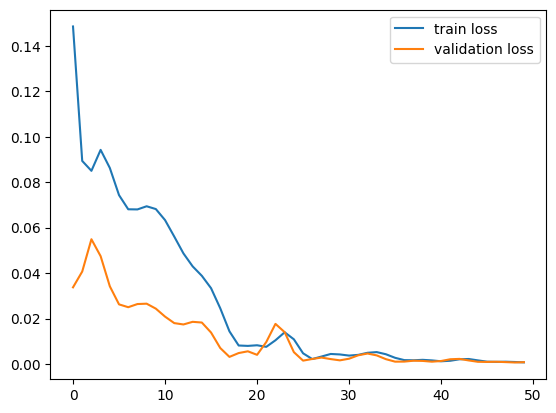

In [188]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

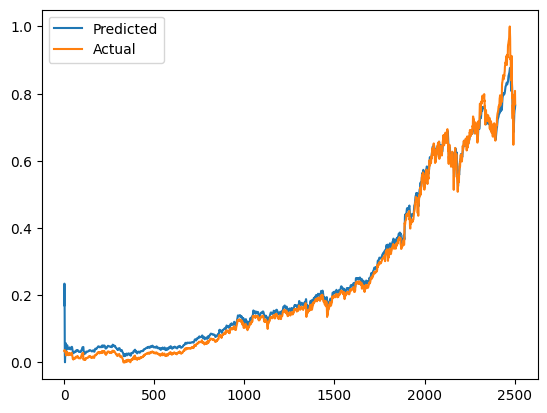

RMSE:  0.020682701797632895


In [189]:
test_model(vanilla_model,X_test,Y_test)

#### Testing on Different Stock

In [190]:
test_data_A,val_data_A,train_data_A=get_data(data_test)

train_x,train_y=genrate_data(test_data_A,20)
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

#test data
test_x,test_y=genrate_data(val_data_A,20)
X_test=pre_process_data(test_x)
Y_test=pre_process_data(test_y)

#validation data
val_x,val_y=genrate_data(train_data_A,20)
X_val=pre_process_data(val_x)
Y_val=pre_process_data(val_y)

In [191]:
vanilla_model=Vanila_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 4, training loss : 0.05727725848555565
epoch 9, training loss : 0.028958598151803017
epoch 14, training loss : 0.035455990582704544
epoch 19, training loss : 0.022442953661084175
epoch 24, training loss : 0.01664798893034458
epoch 29, training loss : 0.009882336482405663
epoch 34, training loss : 0.004313643090426922
epoch 39, training loss : 0.0026446343399584293
epoch 44, training loss : 0.0024916615802794695
epoch 49, training loss : 0.0020226442720741034


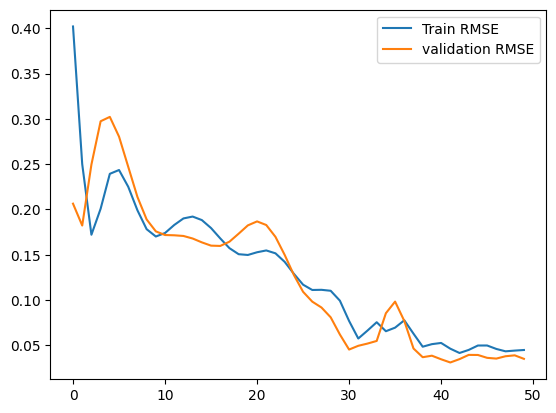

In [192]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

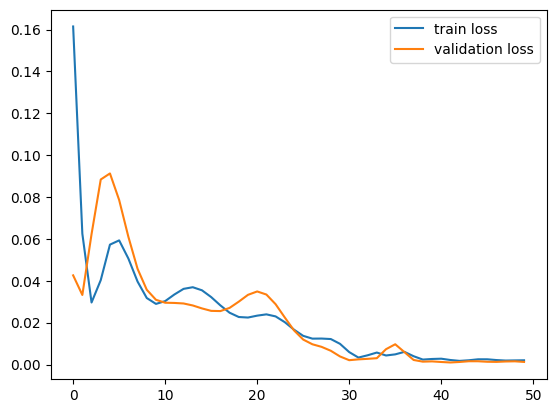

In [193]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

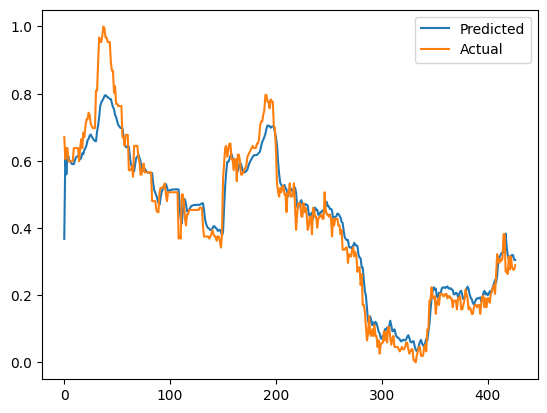

RMSE:  0.054993924752298196


In [194]:
test_model(vanilla_model,X_test,Y_test)

#### Multivariate RNN

In [195]:
epochs=100

In [196]:
class Vanila_RNN_multi(nn.Module):
    def __init__(self):
        super(Vanila_RNN_multi,self).__init__()
        self.input_size=2
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,_status=self.rnn(X,h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out

In [197]:
data=pd.read_csv("./Dataset/ADBE.csv")  # ADOBE Stock Data
data=data.iloc[:,[1,4]]

data_test=pd.read_csv("./Dataset/ABUS.csv")  #ABUS Stock Data
data_test=data_test.iloc[:,[1,4]] 

test_data,val_data,train_data=get_data_multi(data)
test_data_A,val_data_A,train_data_A=get_data_multi(data_test)


train_x,train_y=genrate_data(train_data,20)
train_y=train_y[:,:-1]
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

#test data
test_x,test_y=genrate_data(test_data,20)
test_y=test_y[:,:-1]
X_test=pre_process_data(test_x)
Y_test=pre_process_data(test_y)

#validation data
val_x,val_y=genrate_data(val_data,20)
val_y=val_y[:,:-1]
X_val=pre_process_data(val_x)
Y_val=pre_process_data(val_y)




In [198]:
vanilla_model=Vanila_RNN_multi()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 4, training loss : 0.03311511501669884
epoch 9, training loss : 0.008053740486502647
epoch 14, training loss : 0.0022255938965827227
epoch 19, training loss : 0.002881804946810007
epoch 24, training loss : 0.0015528732910752296
epoch 29, training loss : 0.0009555687429383397
epoch 34, training loss : 0.0008719103643670678
epoch 39, training loss : 0.0007342390017583966
epoch 44, training loss : 0.0006475214613601565
epoch 49, training loss : 0.00048069286276586354
epoch 54, training loss : 0.0003695241757668555
epoch 59, training loss : 0.00033610459649935365
epoch 64, training loss : 0.0002999423595611006
epoch 69, training loss : 0.00027539642178453505
epoch 74, training loss : 0.00024136794672813267
epoch 79, training loss : 0.00023374576994683594
epoch 84, training loss : 0.0002123468875652179
epoch 89, training loss : 0.00020274781854823232
epoch 94, training loss : 0.00019175313354935497
epoch 99, training loss : 0.000182203424628824


##### Train and Validation RMSE Plots

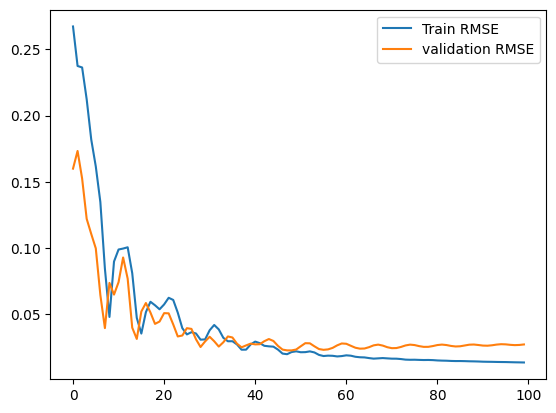

In [199]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

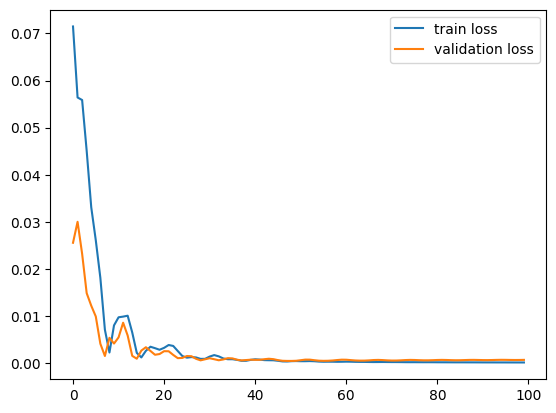

In [200]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

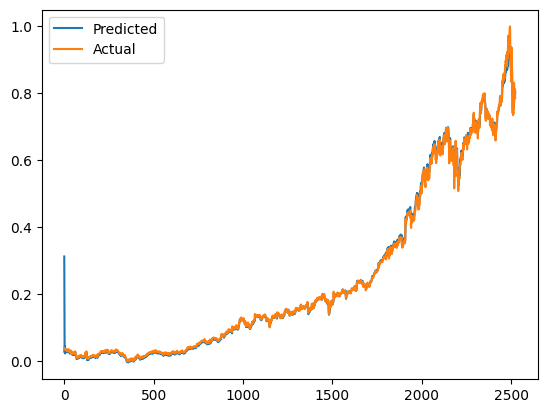

RMSE:  0.010924174741707026


In [201]:
test_model(vanilla_model,X_test,Y_test)